In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os

In [2]:
!wget --no-check-certificate 'https://cdn.discordapp.com/attachments/1209871752134529066/1249007689183268864/reduced_dataset.zip?ex=666b028e&is=6669b10e&hm=eeea460b57a92dd6551b1b4c88f302a715d1c36bd1bb7730a298ff1131e02ab8&' -O ../reduced_dataset.zip
!unzip ../reduced_dataset.zip
!mv reduced_dataset ..

Output streaming troncato alle ultime 5000 righe.
  inflating: reduced_dataset/dataset/audio/right/b737ee80_nohash_1.wav  
  inflating: reduced_dataset/dataset/audio/right/b7a0754f_nohash_2.wav  
  inflating: reduced_dataset/dataset/audio/right/b83c1acf_nohash_4.wav  
  inflating: reduced_dataset/dataset/audio/right/b8c48ffb_nohash_1.wav  
  inflating: reduced_dataset/dataset/audio/right/b93528e3_nohash_0.wav  
  inflating: reduced_dataset/dataset/audio/right/b959cd0c_nohash_0.wav  
  inflating: reduced_dataset/dataset/audio/right/b97c9f77_nohash_0.wav  
  inflating: reduced_dataset/dataset/audio/right/b9f46737_nohash_2.wav  
  inflating: reduced_dataset/dataset/audio/right/b9f46737_nohash_3.wav  
  inflating: reduced_dataset/dataset/audio/right/ba59cab3_nohash_0.wav  
  inflating: reduced_dataset/dataset/audio/right/ba59cab3_nohash_1.wav  
  inflating: reduced_dataset/dataset/audio/right/bcdaa7a9_nohash_3.wav  
  inflating: reduced_dataset/dataset/audio/right/bd11a2e7_nohash_2.wav  
 

In [3]:
train_ds, validation_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='../reduced_dataset/dataset/audio',
    validation_split=0.4, # stiamo mettendo da parte il 40% del dataset, che sarà suddiviso in validation set e test set
    shuffle=True,
    subset='both', # necessario se stiamo utilizzando validation_split (se no darebbe errore)
    seed=0 # necessario se stiamo utilizzando sia shuffle che validation_split (se no darebbe errore)
)

label_names = train_ds.class_names

Found 12933 files belonging to 30 classes.
Using 7760 files for training.
Using 5173 files for validation.


In [4]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

# fonte: funzione presa dal seguente link: https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

In [5]:
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
validation_ds = validation_ds.map(squeeze, tf.data.AUTOTUNE)

audio, label = next(iter(train_ds))
print(audio.shape)
print(label.shape)

(32, 16000)
(32,)


In [7]:
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)

    return spectrogram[..., tf.newaxis]

# fonte: funzione presa dal seguente link: https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

In [8]:
def get_spectrogram_dataset(dataset):
    dataset = dataset.map(lambda x, y: (get_spectrogram(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    return dataset

# fonte: funzione presa dal seguente link: https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

In [9]:
train_ds = get_spectrogram_dataset(train_ds)
validation_ds = get_spectrogram_dataset(validation_ds)

val_ds = validation_ds.take(validation_ds.cardinality() // 2) # ho cambiato nome del validation_ds in modo tale da non creare problemi con l'istruzione seguente
test_ds = validation_ds.skip(validation_ds.cardinality() // 2)

In [10]:
class VoxProfunda():
    def __init__(self):
        self.counter = 0

    def conv2D_x(self, filters, kernel_size, conv_n_layers, repeat, strides=1, padding="valid", name=False):
        self.counter += 1

        if name == False:
            if self.counter == repeat:
                name = "conv" + str(self.counter)
            else:
                name = "conv" + str(self.counter) + "_" + str(repeat)

        conv2D =  tf.keras.Sequential(name=name)

        for repetition in range(repeat):
            for layer in range(conv_n_layers):
                conv2D.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding))
            conv2D.add(tf.keras.layers.BatchNormalization())
            conv2D.add(tf.keras.layers.Activation("relu"))

        return conv2D

    def get_model(self):
        inputs = tf.keras.Input(shape=(124, 129, 1), name="input")
        resize = tf.keras.layers.Resizing(120, 120, name="resize")(inputs)
        normalization = tf.keras.layers.Normalization(name="normalization")(resize)

        # Blocco di apprendimento delle caratteristiche
        # conv1
        conv1 = self.conv2D_x(filters=64, kernel_size=(7,7), conv_n_layers=1, repeat=1, padding="same")(normalization)

        # pool1
        pool1 = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, padding="same", name="pool1")(conv1)

        # conv2_x * 3
        conv2_3 = self.conv2D_x(filters=64, kernel_size=(3,3), conv_n_layers=2, repeat=3, padding="same")(pool1)

        # conv3_x * 4
        conv3_4 = self.conv2D_x(filters=128, kernel_size=(3,3), conv_n_layers=2, repeat=4, padding="same")(conv2_3)

        # conv4_x * 6
        conv4_6 = self.conv2D_x(filters=256, kernel_size=(3,3), conv_n_layers=2, repeat=6, padding="same")(conv3_4)

        # conv4_x * 3
        conv5_3 = self.conv2D_x(filters=512, kernel_size=(3,3), conv_n_layers=2, repeat=3, padding="same")(conv4_6)

        # global average pooling
        global_average_pooling = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(conv5_3)

        # fc1
        fc1 = tf.keras.layers.Dense(512, activation="relu", name="fc1")(global_average_pooling)
        fc2 = tf.keras.layers.Dense(512, activation="relu", name="fc2")(fc1)

        outputs = tf.keras.layers.Dense(30, activation="softmax", name="fc3")(fc2)
        return tf.keras.Model(inputs=inputs, outputs=outputs)


model = VoxProfunda()
model = model.get_model()
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 124, 129, 1)]     0         
                                                                 
 resize (Resizing)           (None, 120, 120, 1)       0         
                                                                 
 normalization (Normalizati  (None, 120, 120, 1)       3         
 on)                                                             
                                                                 
 conv1 (Sequential)          (None, 120, 120, 64)      3456      
                                                                 
 pool1 (MaxPooling2D)        (None, 60, 60, 64)        0         
                                                                 
 conv2_3 (Sequential)        (None, 60, 60, 64)        222336    
                                                             

Un esempio semplificato di architettura VGGVox potrebbe essere:

Blocco Convoluzionale 1:
Conv (3x3, 64) + ReLU
Max-Pooling (2x2) strides 2

Blocco Convoluzionale 2:
Conv (3x3, 128) + ReLU
Max-Pooling (2x2)

Blocco Convoluzionale 3:
Conv (3x3, 256) + ReLU
Conv (3x3, 256) + ReLU
Max-Pooling (2x2)

Fully Connected Layers:
FC (512) + ReLU
FC (4096) + ReLU

Softmax (30)

In [ ]:
def get_model():
    inputs = tf.keras.Input(shape=(124, 129, 1), name="input")
    resize = tf.keras.layers.Resizing(120, 120, name="resize")(inputs)
    normalization = tf.keras.layers.Normalization(name="normalization")(resize)

    # conv1
    conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", name="conv1")(normalization)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, name="pool1")(conv1)

    # conv2_x * 3
    conv2 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", name="conv2")(pool1)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=2, name="pool2")(conv2)

    # conv3_x * 4
    conv3 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", name="conv3")(pool2)
    conv3 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", name="conv3_2")(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=2, name="pool3")(conv3)

    # flatten
    flatten = layers.Flatten(name="flatten")(pool3)

    # fc
    fc1 = layers.Dense(512, activation="relu", name="fc1")(flatten)
    dropout = layers.Dropout(0.5, name="dropout1")(fc1)
    fc2 = layers.Dense(5994, activation="relu", name="fc2")(dropout)
    dropout = layers.Dropout(0.5, name="dropout2")(fc2)
    outputs = layers.Dense(30, activation="softmax", name="softmax")(dropout)

    return models.Model(inputs=inputs, outputs=outputs)

model = get_model()
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
model.summary()

Model: "functional_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 124, 129, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resize (Resizing)               │ (None, 120, 120, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 120, 120, 1)    │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Sequential)              │ (None, 120, 120, 64)   │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_3 (Sequential)            │ (None, 60, 60, 64)     │       222,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_4 (Sequential)            │ (None, 60, 60, 128)    │     1,108,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_6 (Sequential)            │ (None, 60, 60, 256)    │     6,792,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5_3 (Sequential)            │ (None, 60, 60, 512)    │    12,985,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Conv2D)                    │ (None, 52, 60, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_time                       │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 5994)           │     3,074,922 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Dense)                 │ (None, 30)             │       179,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,726,903 (101.96 MB)

 Trainable params: 26,719,220 (101.93 MB)

 Non-trainable params: 7,683 (30.02 KB)

In [ ]:
callback = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/resnet34.keras", save_best_only=True, monitor="val_loss")]
history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=callback)

Epoch 1/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 434s 2s/step - accuracy: 0.0795 - loss: 3.3597 - val_accuracy: 0.3187 - val_loss: 2.3259
Epoch 2/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.4039 - loss: 1.9631 - val_accuracy: 0.5421 - val_loss: 1.7147
Epoch 3/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - accuracy: 0.6322 - loss: 1.2248 - val_accuracy: 0.7025 - val_loss: 1.0428
Epoch 4/100
  2/243 ━━━━━━━━━━━━━━━━━━━━ 7:44 2s/step - accuracy: 0.6875 - loss: 0.9174

KeyboardInterrupt: 

In [ ]:
class VoxProfunda():
    def __init__(self):
        self.counter = 0

    def conv2D_x(self, filters, kernel_size, conv_n_layers, repeat, strides=1, padding="valid", name=False):
        self.counter += 1

        if name == False:
            if self.counter == repeat:
                name = "conv" + str(self.counter)
            else:
                name = "conv" + str(self.counter) + "_" + str(repeat)

        conv2D =  tf.keras.Sequential(name=name)

        for repetition in range(repeat):
            for layer in range(conv_n_layers):
                conv2D.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding))
            conv2D.add(tf.keras.layers.BatchNormalization())
            conv2D.add(tf.keras.layers.Activation("relu"))

        return conv2D

    def get_model(self):
        inputs = tf.keras.Input(shape=(124, 129, 1), name="input")
        resize = tf.keras.layers.Resizing(120, 120, name="resize")(inputs)
        normalization = tf.keras.layers.Normalization(name="normalization")(resize)

        # Blocco di apprendimento delle caratteristiche
        # conv1
        conv1 = self.conv2D_x(filters=64, kernel_size=(7,7), conv_n_layers=1, repeat=1, strides=2, padding="same")(normalization)

        # pool1
        pool1 = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, padding="same", name="pool1")(conv1)

        # conv2_x * 3
        conv2_3 = self.conv2D_x(filters=64, kernel_size=(3,3), conv_n_layers=2, repeat=3, padding="same")(pool1)

        # conv3_x * 4
        conv3_4 = self.conv2D_x(filters=128, kernel_size=(3,3), conv_n_layers=2, repeat=4, padding="same")(conv2_3)

        # conv4_x * 6
        conv4_6 = self.conv2D_x(filters=256, kernel_size=(3,3), conv_n_layers=2, repeat=6, padding="same")(conv3_4)

        # conv4_x * 3
        conv5_3 = self.conv2D_x(filters=512, kernel_size=(3,3), conv_n_layers=2, repeat=3, padding="same")(conv4_6)

        # global average pooling
        fc1 = tf.keras.layers.Conv2D(filters=512, kernel_size=(9, 1), strides=1, activation="relu", name="fc1")(conv5_3)

        # pool_time
        avg_pooling = tf.keras.layers.GlobalAveragePooling2D(name="pool_time")(fc1)

        # fc2
        fc2 = layers.Dense(5994, activation="relu", name="fc2")(avg_pooling)

        # softmax
        outputs = layers.Dense(30, activation="softmax", name="softmax")(fc2)

        return models.Model(inputs=inputs, outputs=outputs)



model = VoxProfunda()
model = model.get_model()
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
model.summary()

Model: "functional_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 124, 129, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resize (Resizing)               │ (None, 120, 120, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 120, 120, 1)    │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Sequential)              │ (None, 60, 60, 64)     │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_3 (Sequential)            │ (None, 30, 30, 64)     │       222,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_4 (Sequential)            │ (None, 30, 30, 128)    │     1,108,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_6 (Sequential)            │ (None, 30, 30, 256)    │     6,792,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5_3 (Sequential)            │ (None, 30, 30, 512)    │    12,985,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Conv2D)                    │ (None, 22, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_time                       │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 5994)           │     3,074,922 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Dense)                 │ (None, 30)             │       179,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,726,903 (101.96 MB)

 Trainable params: 26,719,220 (101.93 MB)

 Non-trainable params: 7,683 (30.02 KB)

In [14]:
class VoxProfunda():
    def __init__(self):
        self.counter = 0

    def conv2D_x(self, filters, kernel_size, conv_n_layers, repeat, strides=1, padding="valid", name=False):
        self.counter += 1

        if name == False:
            if self.counter == repeat:
                name = "conv" + str(self.counter)
            else:
                name = "conv" + str(self.counter) + "_" + str(repeat)

        conv2D =  tf.keras.Sequential(name=name)

        for repetition in range(repeat):
            for layer in range(conv_n_layers):
                conv2D.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding))
            conv2D.add(tf.keras.layers.BatchNormalization())
            conv2D.add(tf.keras.layers.Activation("relu"))

        return conv2D

    def residual_block(self, x, filters, kernel_size, conv_n_layers, repeat, strides=1, padding="valid", name=False, pooling=False):
        residual = x
        x = self.conv2D_x(filters, kernel_size, conv_n_layers, repeat, strides, padding, name)(x)
        if pooling:
            x = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, padding="same")(x)
            residual = tf.keras.layers.Conv2D(filters, 1, strides=4)(residual)
        elif filters != residual.shape[-1]:
            residual = tf.keras.layers.Conv2D(filters, 1)(residual)

        output_layer = tf.keras.layers.add([x, residual])
        return output_layer

    def get_model(self):
        inputs = tf.keras.Input(shape=(124, 129, 1), name="input")
        resize = tf.keras.layers.Resizing(120, 120, name="resize")(inputs)
        normalization = tf.keras.layers.Normalization(name="normalization")(resize)

        # Blocco di apprendimento delle caratteristiche
        # conv1
        conv1 = self.residual_block(normalization,filters=64, kernel_size=(7,7), conv_n_layers=1, repeat=1, strides=2, padding="same", pooling=True)

        # conv2_x * 3
        conv2_3 = self.residual_block(conv1, filters=64, kernel_size=(3,3), conv_n_layers=2, repeat=3, padding="same")

        # conv3_x * 4
        conv3_4 = self.residual_block(conv2_3, filters=128, kernel_size=(3,3), conv_n_layers=2, repeat=4, padding="same")

        # conv4_x * 6
        conv4_6 = self.residual_block(conv3_4, filters=256, kernel_size=(3,3), conv_n_layers=2, repeat=6, padding="same")

        # conv4_x * 3
        conv5_3 = self.residual_block(conv4_6, filters=512, kernel_size=(3,3), conv_n_layers=2, repeat=3, padding="same")

        # global average pooling
        fc1 = tf.keras.layers.Conv2D(filters=512, kernel_size=(9, 1), strides=1, activation="relu", name="fc1")(conv5_3)

        # pool_time
        avg_pooling = tf.keras.layers.GlobalAveragePooling2D(name="pool_time")(fc1)

        # fc2
        fc2 = tf.keras.layers.Dense(5994, activation="relu", name="fc2")(avg_pooling)

        # softmax
        outputs = tf.keras.layers.Dense(30, activation="softmax", name="softmax")(fc2)

        return tf.keras.models.Model(inputs=inputs, outputs=outputs)

model = VoxProfunda()
model = model.get_model()
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 124, 129, 1)]        0         []                            
                                                                                                  
 resize (Resizing)           (None, 120, 120, 1)          0         ['input[0][0]']               
                                                                                                  
 normalization (Normalizati  (None, 120, 120, 1)          3         ['resize[0][0]']              
 on)                                                                                              
                                                                                                  
 conv1 (Sequential)          (None, 60, 60, 64)           3456      ['normalization[0][0]'] 

In [15]:
callback = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/resnet34.keras", save_best_only=True, monitor="val_loss")]
history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=callback)

Epoch 1/100
243/243 [==============================] - 89s 265ms/step - loss: 3.2156 - accuracy: 0.0986 - val_loss: 2.8611 - val_accuracy: 0.1454
Epoch 2/100
243/243 [==============================] - 56s 232ms/step - loss: 2.3817 - accuracy: 0.2829 - val_loss: 7.9057 - val_accuracy: 0.1076
Epoch 3/100
243/243 [==============================] - 58s 240ms/step - loss: 1.6296 - accuracy: 0.5090 - val_loss: 2.2335 - val_accuracy: 0.3742
Epoch 4/100
243/243 [==============================] - 57s 233ms/step - loss: 1.0939 - accuracy: 0.6675 - val_loss: 2.4188 - val_accuracy: 0.4931
Epoch 5/100
243/243 [==============================] - 58s 239ms/step - loss: 0.8986 - accuracy: 0.7244 - val_loss: 1.2817 - val_accuracy: 0.6597
Epoch 6/100
243/243 [==============================] - 57s 233ms/step - loss: 0.7090 - accuracy: 0.7784 - val_loss: 1.5799 - val_accuracy: 0.5914
Epoch 7/100
243/243 [==============================] - 58s 240ms/step - loss: 0.6138 - accuracy: 0.8099 - val_loss: 0.8208 -

In [16]:
import pickle

with open('resnet34_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [17]:
def create_train_val_plot(history, overfit=True):
    # definisco numero epoche
    epochs = range(1, len(history['accuracy']) + 1)

    # Accuracy
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    fig_acc, ax_acc = plt.subplots()

    # linea di base
    ax_acc.plot(epochs, [0.5 for x in range(len(epochs))], color="lightgray", linestyle="--", label="Base")
    # linee di accuratezza
    ax_acc.plot(epochs, accuracy, color="slategray", label="Accuratezza in addestramento")
    ax_acc.plot(epochs, val_accuracy, color="indianred", label="Accuratezza in validazione")
    # miglior accuratezza validazione
    ax_acc.axhline(y=max(val_accuracy), c='indianred', alpha=0.7, linestyle='--')
    ax_acc.text(len(epochs) * 1.07, max(val_accuracy), round(max(val_accuracy), 2), fontsize=9, fontweight="bold", horizontalalignment="left", verticalalignment="center")
    # nascondo limiti plot
    ax_acc.spines["right"].set_visible(False)
    ax_acc.spines["top"].set_visible(False)
    ax_acc.spines["left"].set_visible(False)
    # definizione label e titolo + legenda
    ax_acc.set_title("Accuratezza in addestramento e validazione")
    ax_acc.set_xlabel("Epoche")
    ax_acc.set_ylabel("Accuratezza (%)")
    ax_acc.legend()

    # Loss
    loss = history['loss']
    val_loss = history['val_loss']

    fig_loss, ax_loss = plt.subplots()

    # linee di loss
    ax_loss.plot(epochs, loss, color="slategray", label="Perdita in addestramento")
    ax_loss.plot(epochs, val_loss, color="indianred", label="Perdita in validazione")
    # miglior loss validazione
    ax_loss.axhline(y=min(val_loss), c='indianred', alpha=0.7, linestyle='--')
    ax_loss.text(len(epochs) * 1.07, min(val_loss), round(min(val_loss), 2), fontsize=9, fontweight="bold", horizontalalignment="left", verticalalignment="center")
    # nascondo limiti plot
    ax_loss.spines["right"].set_visible(False)
    ax_loss.spines["top"].set_visible(False)
    ax_loss.spines["left"].set_visible(False)
    # definizione label e titolo + legenda
    ax_loss.set_title("Perdita in addestramento e validazione")
    ax_loss.set_xlabel("Epoche")
    ax_loss.set_ylabel("Perdita")

    handles, _ = ax_loss.get_legend_handles_labels()

    if overfit:
        # area overfit
        rect = mpatches.Rectangle((np.argmin(val_loss) + 1, 0), width=100 - np.argmin(val_loss), height=max(max(loss), max(val_loss)), color='lightcoral', alpha=0.3)
        ax_loss.add_patch(rect)
        # patch overfit per legenda
        overfit = mpatches.Patch(color='indianred', alpha=0.3, label='Area overfit')
        handles, _ = ax_loss.get_legend_handles_labels()
        handles.append(overfit)

    # legenda
    ax_loss.legend(handles=handles)

    plt.show()

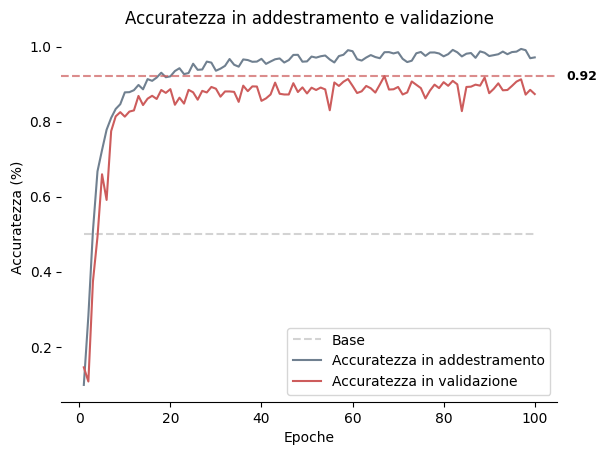

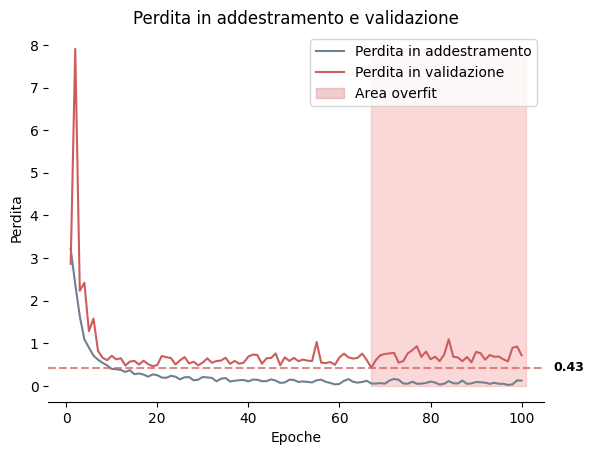

In [18]:
create_train_val_plot(history.history)

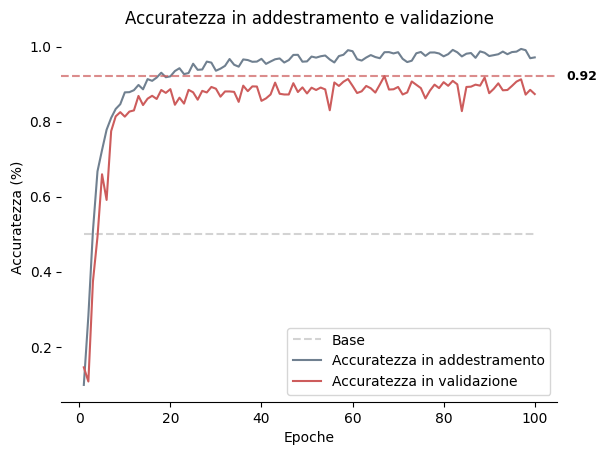

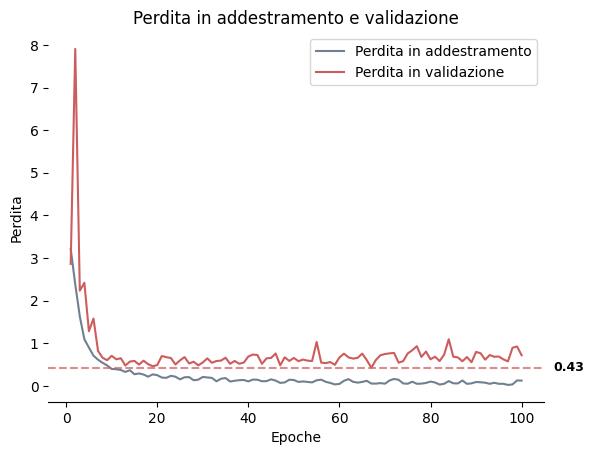

In [19]:
create_train_val_plot(history.history, overfit=False)

Il modello ci ha messo 1 ora e 35 minuti a trainare con la GPU L4 con Ram Avanzata